In [1]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf 
import tensorflow_io as tfio
import numpy as np
import pandas as pd

In [2]:
#Getting the file paths to a 'A-Call audio file' & a 'Non A-Call audio file'.
A_CALL_FILE = os.path.join('/kaggle', 'input', 'datafestintegration2023','train','train','1','01.wav')
NOT_A_CALL_FILE = os.path.join('/kaggle', 'input', 'datafestintegration2023','train','train','0','01.wav')

In [3]:
#File path to the first A-Call audio file
A_CALL_FILE

'/kaggle/input/datafestintegration2023/train/train/1/01.wav'

In [4]:
#File path to the first Non A-Call audio file
NOT_A_CALL_FILE

'/kaggle/input/datafestintegration2023/train/train/0/01.wav'

In [5]:
#Defining a audio file loading function.
def load_wav_1k_mono(filename):
    #Loading the encoded audio file
    file_contents = tf.io.read_file(filename)
    
    #Decoding the contents of the audio file and returns the audio data and its sample rate(Also converts the audio into one channel)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    
    #removing the last dimension from the audio data, which is not needed since the audio is in 1 channel.
    wav = tf.squeeze(wav, axis=-1)
    
    #Changing the sample rate from its original data type to tf.int64. (Helps in resampling)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    
    #Resampling the audio data to have a sample rate of 1000Hz
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=1000)
    
    return wav

In [6]:
file_contents = tf.io.read_file(A_CALL_FILE)

In [7]:
wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)

In [8]:
#Passing the previously defined audio files through the function
wave = load_wav_1k_mono(A_CALL_FILE)
nwave = load_wav_1k_mono(NOT_A_CALL_FILE)

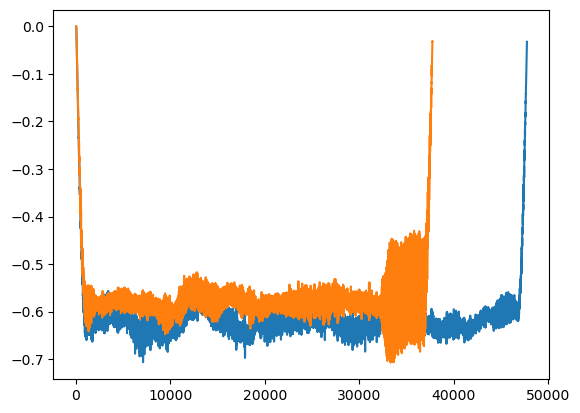

In [9]:
#Plotting the two decoded audio files
plt.plot(wave)
plt.plot(nwave)
plt.show()

In [10]:
#Defining the file paths to A-Calls and Non A-Call audio files directories
Positives = os.path.join('/kaggle', 'input', 'datafestintegration2023','train','train','1')
Negatives = os.path.join('/kaggle', 'input', 'datafestintegration2023','train','train','0')

In [11]:
#Getting all the files as a string in Tensoflow dataset format
pos = tf.data.Dataset.list_files(Positives + '/*.wav')
neg = tf.data.Dataset.list_files(Negatives + '/*.wav')

In [12]:
#Getting a random audio file path in the directory '1'
pos.as_numpy_iterator().next()

b'/kaggle/input/datafestintegration2023/train/train/1/01749.wav'

In [13]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))

In [14]:
print(len(positives))
print(len(negatives))

12995
12951


In [15]:
data = positives.concatenate(negatives)
print(len(data))

25946


In [16]:
data.shuffle(10000).as_numpy_iterator().next()

(b'/kaggle/input/datafestintegration2023/train/train/1/010140.wav', 1.0)

In [17]:
lengths = []
for file in os.listdir(os.path.join('/kaggle', 'input', 'datafestintegration2023','train','train','1')):
    tensor_wave = load_wav_1k_mono(os.path.join('/kaggle', 'input', 'datafestintegration2023','train','train','1', file))
    lengths.append(len(tensor_wave))

In [18]:
lengths[0:5]

[24824, 18039, 17015, 18935, 37368]

In [19]:
len(lengths)

12995

In [20]:
#Mean of the audio file time durations
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=25308>

In [21]:
#Minimum of the audio file time durations
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=16887>

In [22]:
#Maximum of the audio file time durations
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=99832>

In [23]:
#Getting these values helps in deciding to which duration we should trim the files in the preprocessing stage
#Avg = lengths/Frequency
Avg_time = 27838/1000
Lowest_time = 18576/1000
Highest_time = 109815/1000
print(f'Highest duration a the whale call audio file is: {Highest_time}s')
print(f'Lowest duration of a the whale call audio file is: {Lowest_time}s')
print(f'Average duration of a the whale call audio file is: {round(Avg_time,2)}s')

Highest duration a the whale call audio file is: 109.815s
Lowest duration of a the whale call audio file is: 18.576s
Average duration of a the whale call audio file is: 27.84s


In [24]:
#Defining the preprocessing function
def preprocess(file_path, label): 
    #Converting the audio files into single channel audio
    wav = load_wav_1k_mono(file_path)
    
    #Limiting the length of the wave file to 30,000 samples.
    wav = wav[:30000]
    
    #For the files that are shorter than 30,000 samples, pad it with 0s and increase the length to 30,000 samples
    zero_padding = tf.zeros([30000] - tf.shape(wav), dtype=tf.float32)
    
    #Concatenating the zero-padded and the wav tensor along the first dimension to produce a tensor with a length of 30,000 samples.
    wav = tf.concat([zero_padding, wav],0)
    
    #Computing the Short-Time Fourier Transform (STFT) of the wave file. 
    #Optimal frame_length and frame_step parameters are fine tuned to get a better accuracy.
    spectrogram = tf.signal.stft(wav, frame_length=125, frame_step=48)
    
    #Computing the absolute value of the STFT coefficients.
    spectrogram = tf.abs(spectrogram)
    
    #Applying logarithm to the STFT coefficients after adding a small positive constant '1e-15' to avoid taking logarithm of zero.
    #This step improves the spectrogram and visualize the repetitive pattern of pulses.
    spectrogram = tf.math.log(spectrogram + 1e-15)  
    
    #Adding an additional dimension to the STFT coefficients tensor along the third axis to represent the channels of the input audio.
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    
    return spectrogram, label

In [25]:
#Getting a random data from the A-Calls dataset
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [26]:
#Passing the file through the preprocessing function
spectrogram, label = preprocess(filepath, label)

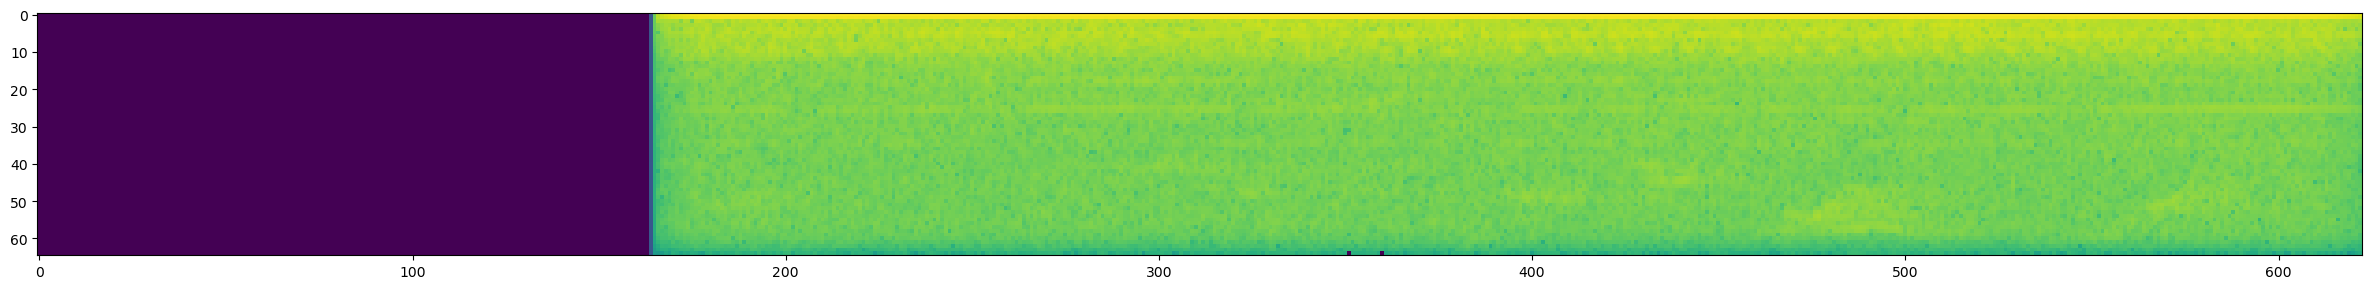

In [27]:
#Spectrogram of a whale A call.
#The repetitive pattern of pulses is visible at the top.
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [28]:
#Getting a random data from the Non A-Calls dataset
filepath, label = negatives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [29]:
#Passing the file through the preprocessing function
spectrogram, label = preprocess(filepath, label)

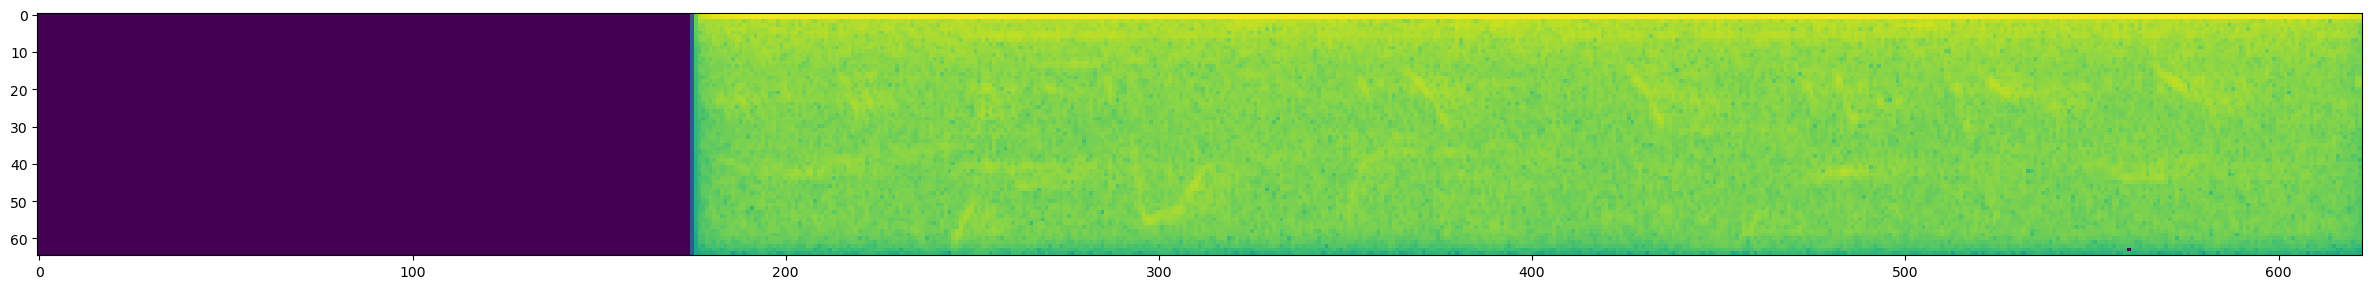

In [30]:
#Spectrogram of not a non call
#There are no repetitive pattern of pulses visible.
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

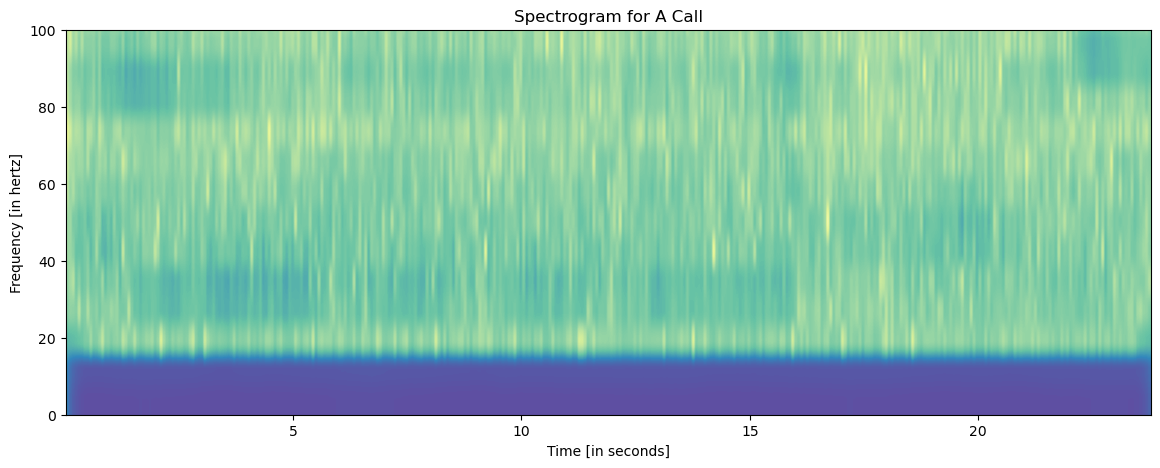

In [31]:
#Another spectrogram of an A-Call but no patterns are visible to the naked eye
plt.figure(figsize=(14, 5))
plt.specgram(wave, Fs=2000, cmap='Spectral')
plt.title('Spectrogram for A Call')
plt.ylim([0, 100])
plt.xlabel('Time [in seconds]')
plt.ylabel('Frequency [in hertz]')
plt.show()

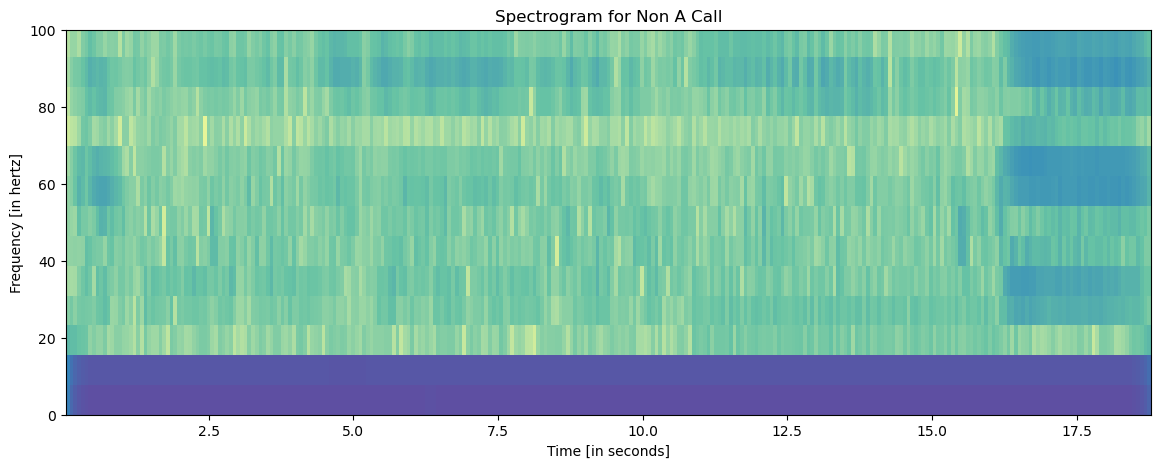

In [32]:
#Another spectrogram of a Non A-Call but no patterns are visible to the naked eye
plt.figure(figsize=(14, 5))
plt.specgram(nwave, Fs=2000, cmap='Spectral')
plt.title('Spectrogram for Non A Call')
plt.ylim([0, 100])
plt.xlabel('Time [in seconds]')
plt.ylabel('Frequency [in hertz]')
plt.show()

In [33]:
#Creating the Tensorflow data pipeline
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=10000)
data = data.batch(16)
data = data.prefetch(8)

In [34]:
#Reviewing the length of the data
len(data)

1622

In [35]:
#Calculating the training data amount(70% of the total data)
len(data)*.7

1135.3999999999999

In [36]:
##Calculating the testing data amount(30% of the total data)
len(data) - 1136

486

In [37]:
#Splitting data into train and test datasets
train = data.take(1136)
test = data.skip(1136).take(486)

In [38]:
#Testing one batch
samples, labels = train.as_numpy_iterator().next()

In [39]:
#Shape of the first batch of 16 samples
samples.shape

(16, 623, 65, 1)

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

In [41]:
#Defining the Sequencial model with CNN layers
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=samples.shape[1:4]))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [42]:
#Defining the model compiling parameters
model.compile(
    'Adam', 
    loss='BinaryCrossentropy', 
    metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()]
)

In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 621, 63, 16)       160       
                                                                 
 conv2d_1 (Conv2D)           (None, 619, 61, 16)       2320      
                                                                 
 flatten (Flatten)           (None, 604144)            0         
                                                                 
 dense (Dense)               (None, 64)                38665280  
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 38,669,873
Trainable params: 38,669,873
No

In [44]:
#Creating a TensorFlow Dataset object from the input samples and labels tensors,
train_dataset = tf.data.Dataset.from_tensor_slices((samples, labels))

#Applying batching to the dataset by grouping the samples and labels into batches of size 16.
train_dataset = train_dataset.batch(16)

#Enabling data pre-fetching
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

In [45]:
#Training the model with 5 epochs.
hist = model.fit(train, epochs=5, validation_data=test)

Epoch 1/5
1136/1136 [==============================] - 761s 653ms/step - loss: 0.8452 - recall: 0.9760 - precision: 0.9209 - val_loss: 0.1099 - val_recall: 0.9282 - val_precision: 0.9103
Epoch 2/5
1136/1136 [==============================] - 703s 619ms/step - loss: 0.0905 - recall: 0.9875 - precision: 0.9659 - val_loss: 0.0467 - val_recall: 0.9557 - val_precision: 0.9817
Epoch 3/5
1136/1136 [==============================] - 665s 586ms/step - loss: 0.0342 - recall: 0.9922 - precision: 0.9874 - val_loss: 0.0211 - val_recall: 0.9887 - val_precision: 0.9845
Epoch 4/5
1136/1136 [==============================] - 659s 580ms/step - loss: 0.0262 - recall: 0.9942 - precision: 0.9930 - val_loss: 0.0155 - val_recall: 0.9901 - val_precision: 0.9971
Epoch 5/5
1136/1136 [==============================] - 670s 589ms/step - loss: 0.0140 - recall: 0.9971 - precision: 0.9960 - val_loss: 0.0035 - val_recall: 1.0000 - val_precision: 0.9963


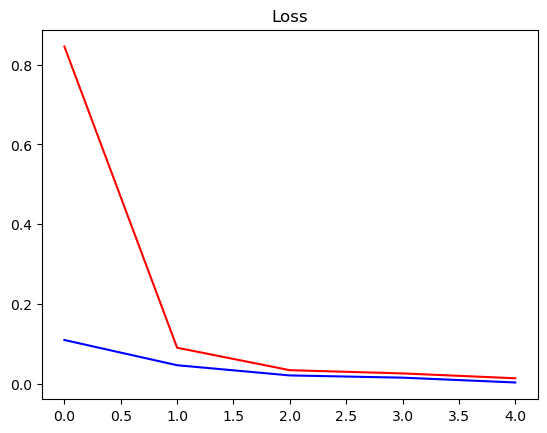

In [46]:
#Plotting the Loss, over time
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

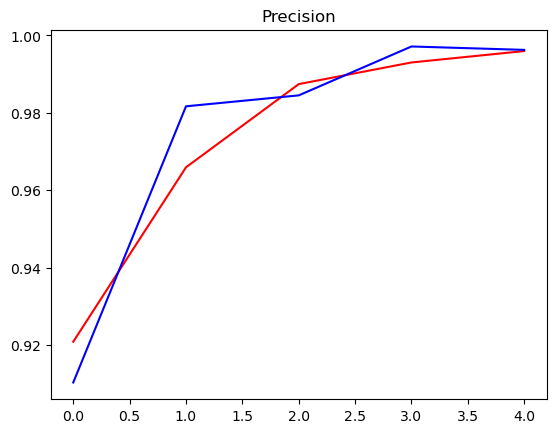

In [47]:
#Plotting the Precision, over time
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

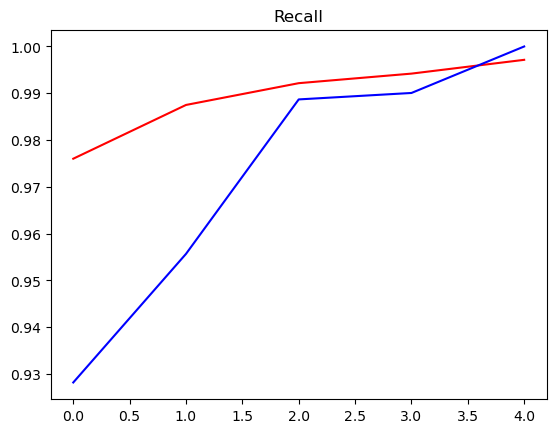

In [48]:
#Plotting the Recall, over time
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

In [49]:
#Splitting the test data into features and labels
X_test, y_test = test.as_numpy_iterator().next()
#Predicting using X_test data
yhat = model.predict(X_test)
#Defining a threshold of 0.5
yhat = [1 if prediction > 0.50 else 0 for prediction in yhat]


1/1 [==============================] - 0s 202ms/step


In [50]:
yhat

[0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1]

In [51]:
#Getting the testing accuracy
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, yhat)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 100.00%


In [52]:
#Defining file path to testing data
Tests = os.path.join('/kaggle', 'input', 'datafestintegration2023','test','test')

In [53]:
#Getting all the files in testing file path as a string in Tensoflow dataset format without shuffling
Test_files = tf.data.Dataset.list_files(Tests + '/*.wav', shuffle=False)

In [54]:
#Labeling all the testing data as 0's in order to use the pre-defined functions
test_data = tf.data.Dataset.zip((Test_files, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
#Mapping the testing data to the pre defined preprocessing function
test_data = test_data.map(preprocess)
#Pipelining testing data in batches of 16 
test_data = test_data.batch(16)
#size of the test_data
len(test_data)

125

In [55]:
#Testing one batch
sample, dummy = test_data.as_numpy_iterator().next()
#Shape of a testing data batch of 16
sample.shape

(16, 623, 65, 1)

In [56]:
#Iterating through all test data, predicting them using the trained model and putting them in an array
all_preds = []

for x_batch, _ in test_data.as_numpy_iterator():
    preds = model.predict(x_batch)
    all_preds.extend(preds)

1/1 [==============================] - 0s 117ms/step


In [57]:
len(all_preds)

2000

In [58]:
#Defining the threshold to 0.50
preds = [1 if prediction > 0.50 else 0 for prediction in all_preds]

In [59]:
#The number of predictions predicted as an A-Call
preds.count(1)
#The number of predictions predicted as a non A-Call
preds.count(0)

1020

In [60]:
#Testing folder path
testAudio_folder = '/kaggle/input/datafestintegration2023/test/test'
#Listing all the audio files to an list
testAudio_list = os.listdir(testAudio_folder)
#Sorting the list
testAudio_list = sorted(testAudio_list)
len(testAudio_list)

2000

In [61]:
#Creating a pandas dataframe with the ID values using the audio file names list
df = pd.DataFrame(testAudio_list, columns=["id"])
#Splitting the audio file name and getting only the ID numbers
df['id'] = df['id'].str.split('.').str[0]
df.head()

,id
0,0
1,1
2,10
3,100
4,1000


In [62]:
#Adding the prediction column with the predictions made earlier
df = df.assign(label=preds)

In [63]:
#Converting the pandas dataframe to a csv file to submit
df.to_csv('submission36.csv',index=None)